In [1]:
%matplotlib inline

#system
import os
import glob

#math
import numpy as np

#video and image
import cv2
import moviepy
from moviepy.editor import VideoFileClip

#display
import matplotlib.pyplot as plt
import matplotlib.image as mplimg


# Camera Calibration

In [2]:
# taken from code in examples folder

#chessboard dimensions
nx, ny = (9, 6)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

#         # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)
# cv2.destroyAllWindows()

# get camera calibration constants
iscalibrated, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### Test extracted camera calibration coefficients on undistorting images

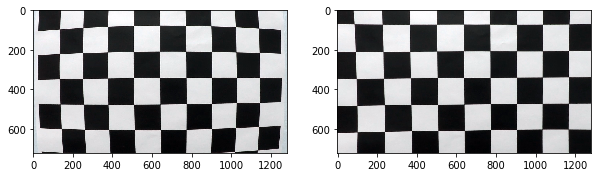

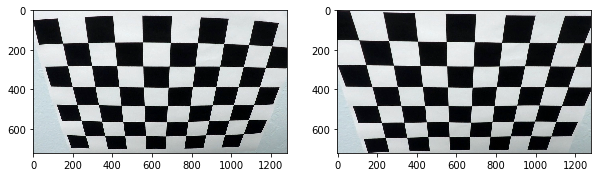

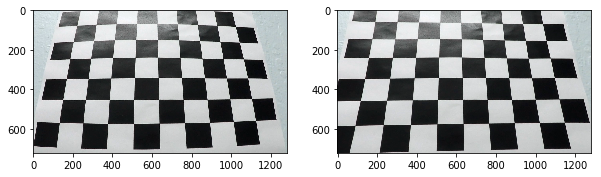

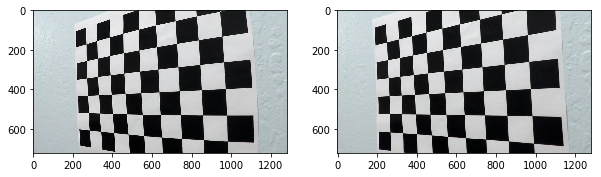

In [3]:
#test camera calibration
for i in range(1,5):
    calibration_img = cv2.imread('camera_cal/calibration{}.jpg'.format(i))
    undistorted_img = cv2.undistort(calibration_img, mtx, dist, None, mtx)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
    ax1.imshow(calibration_img)
    ax2.imshow(undistorted_img)

# Convert to binary image 

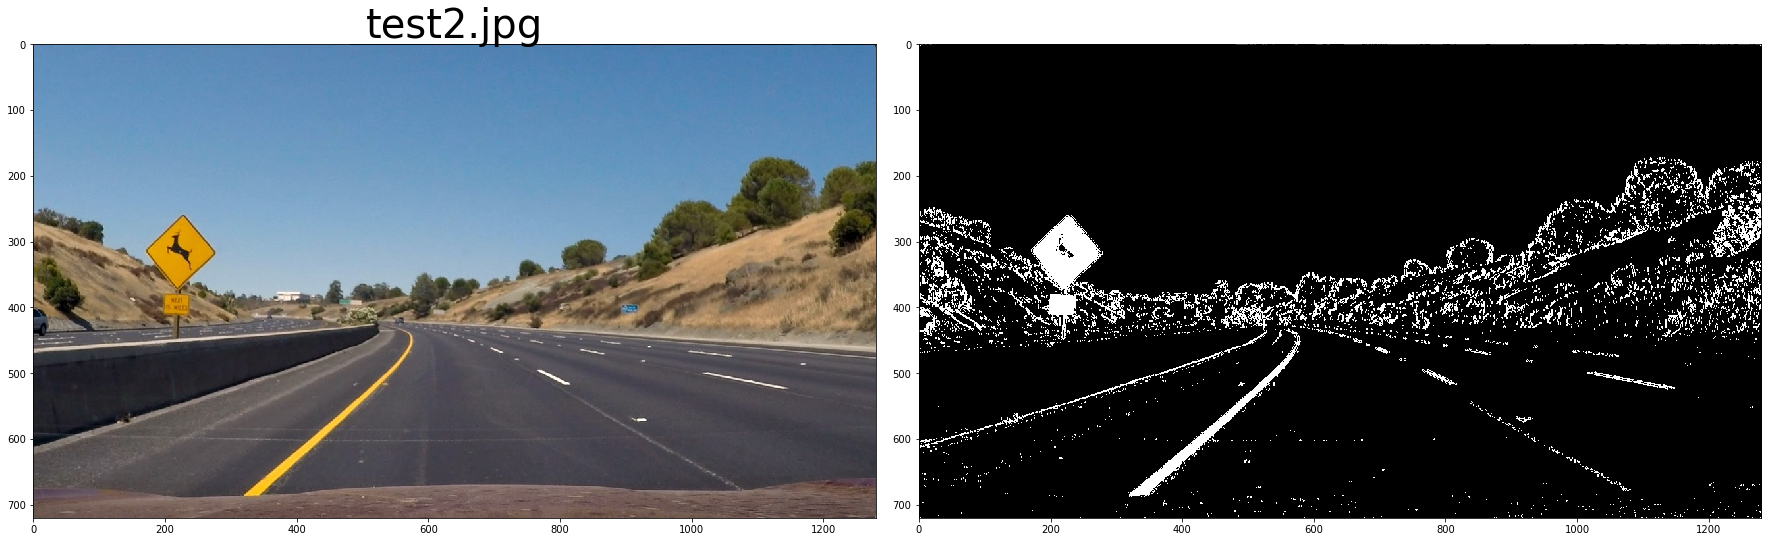

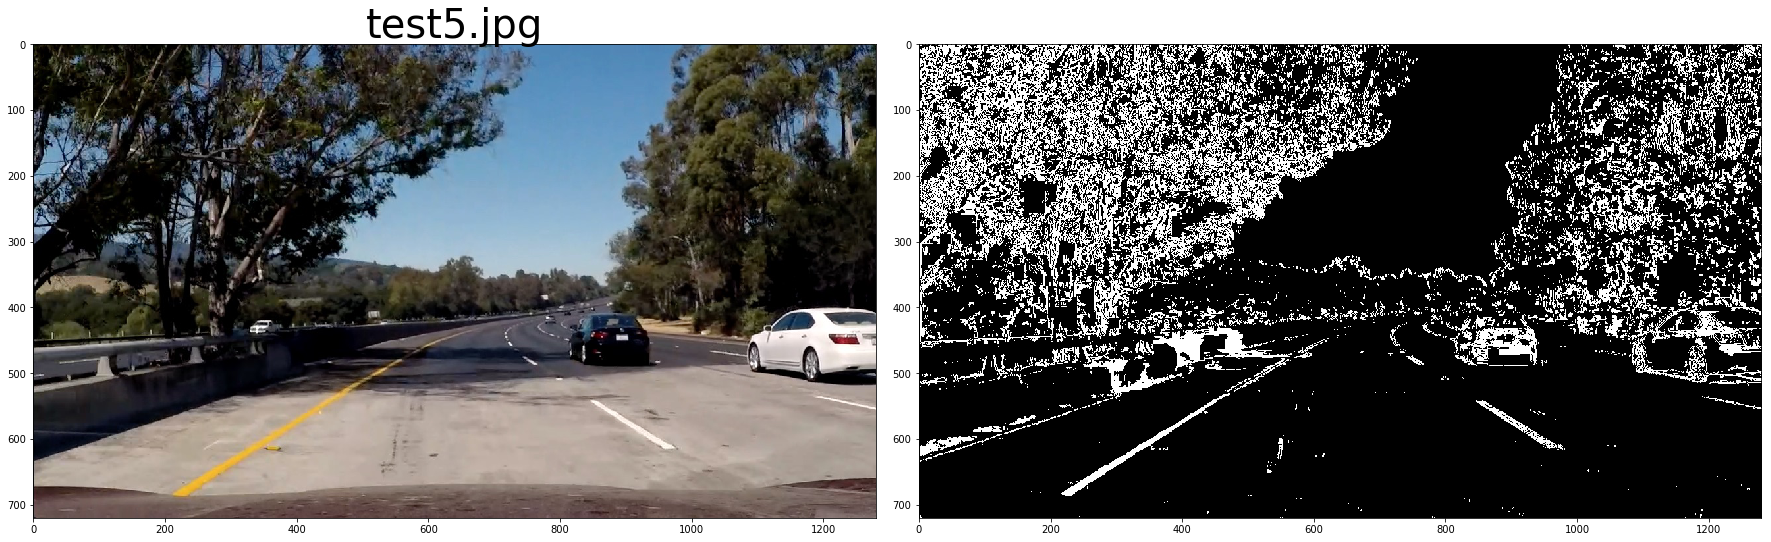

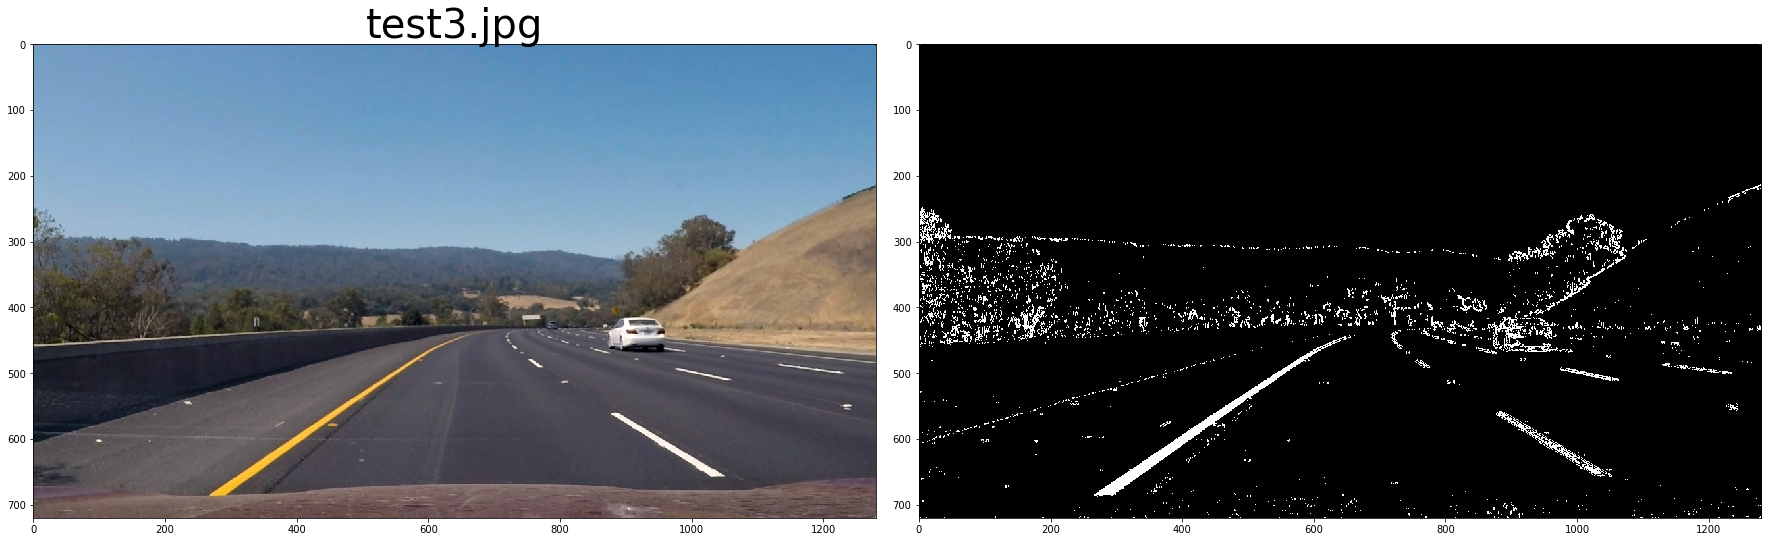

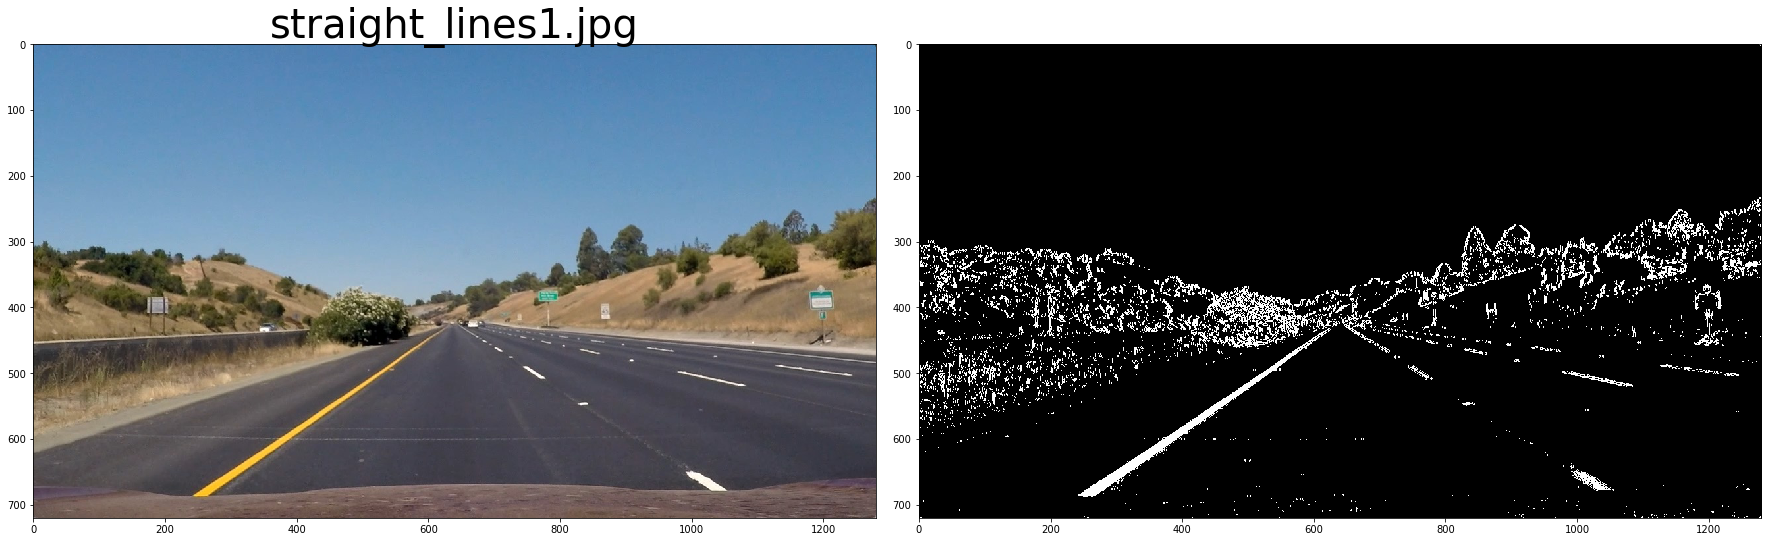

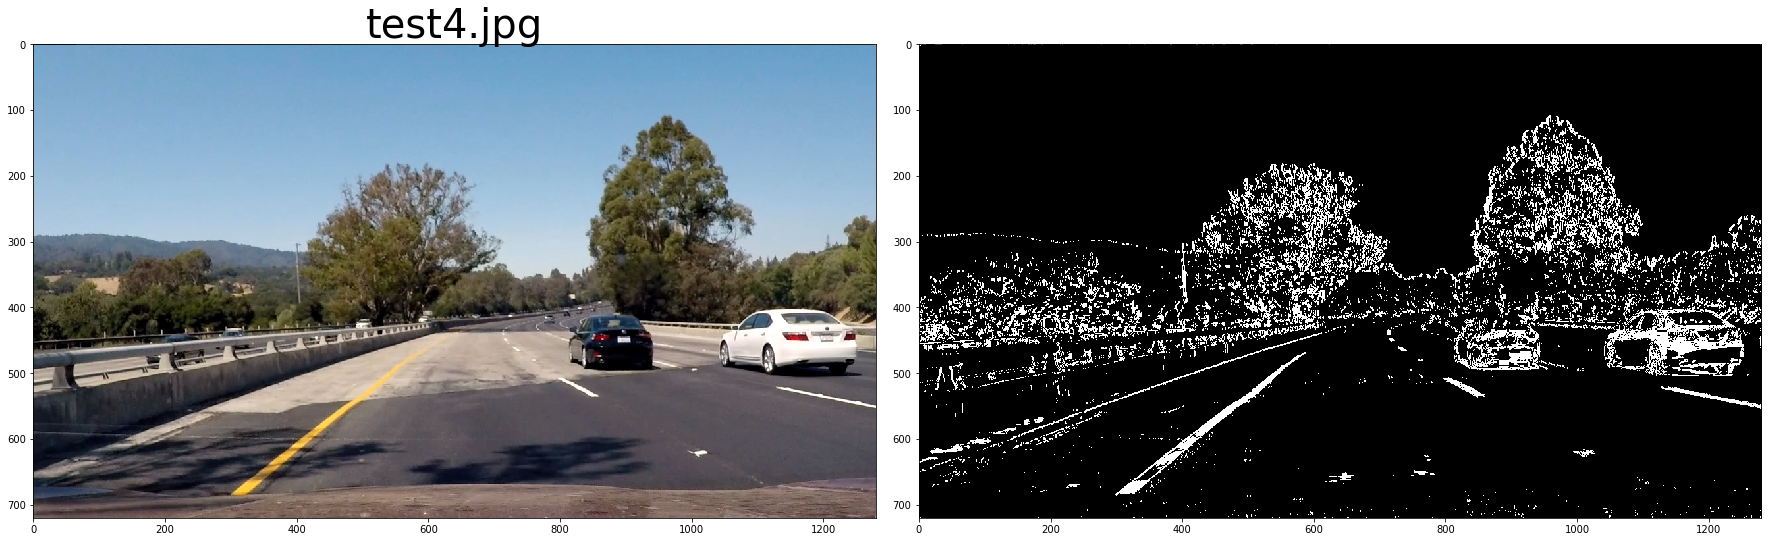

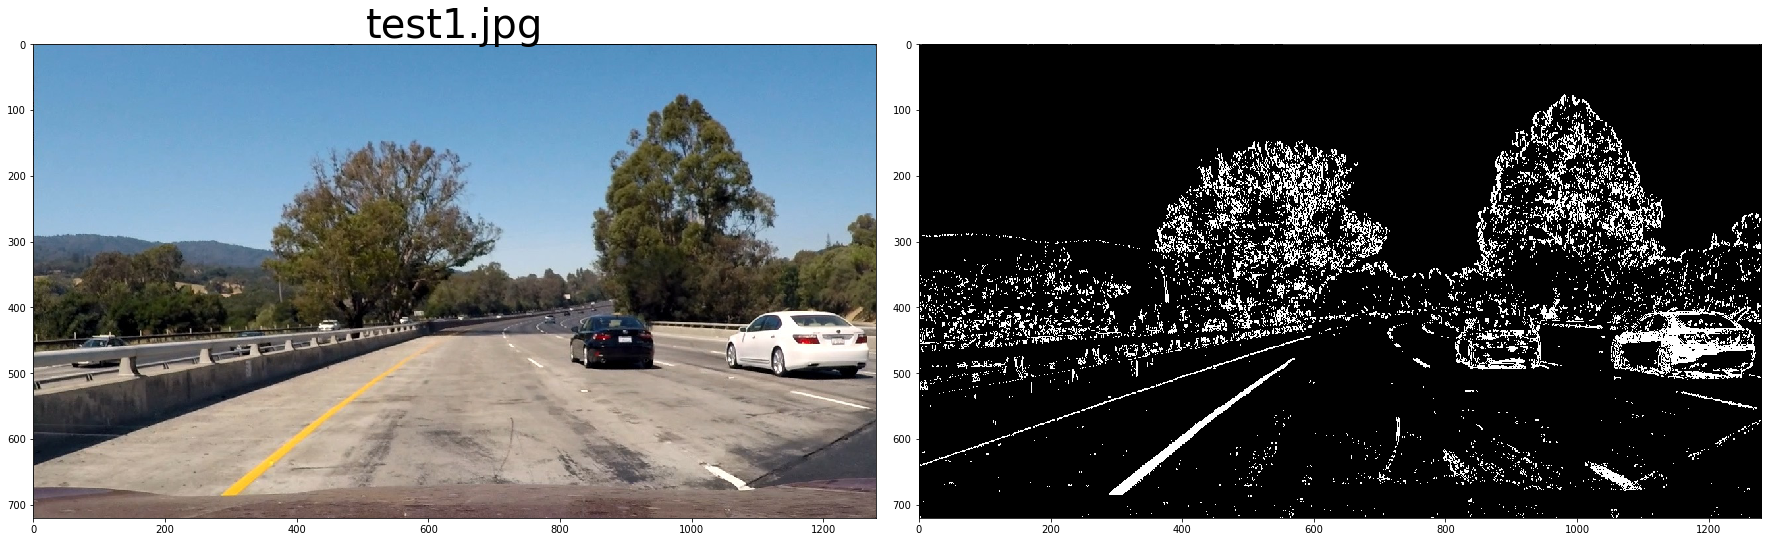

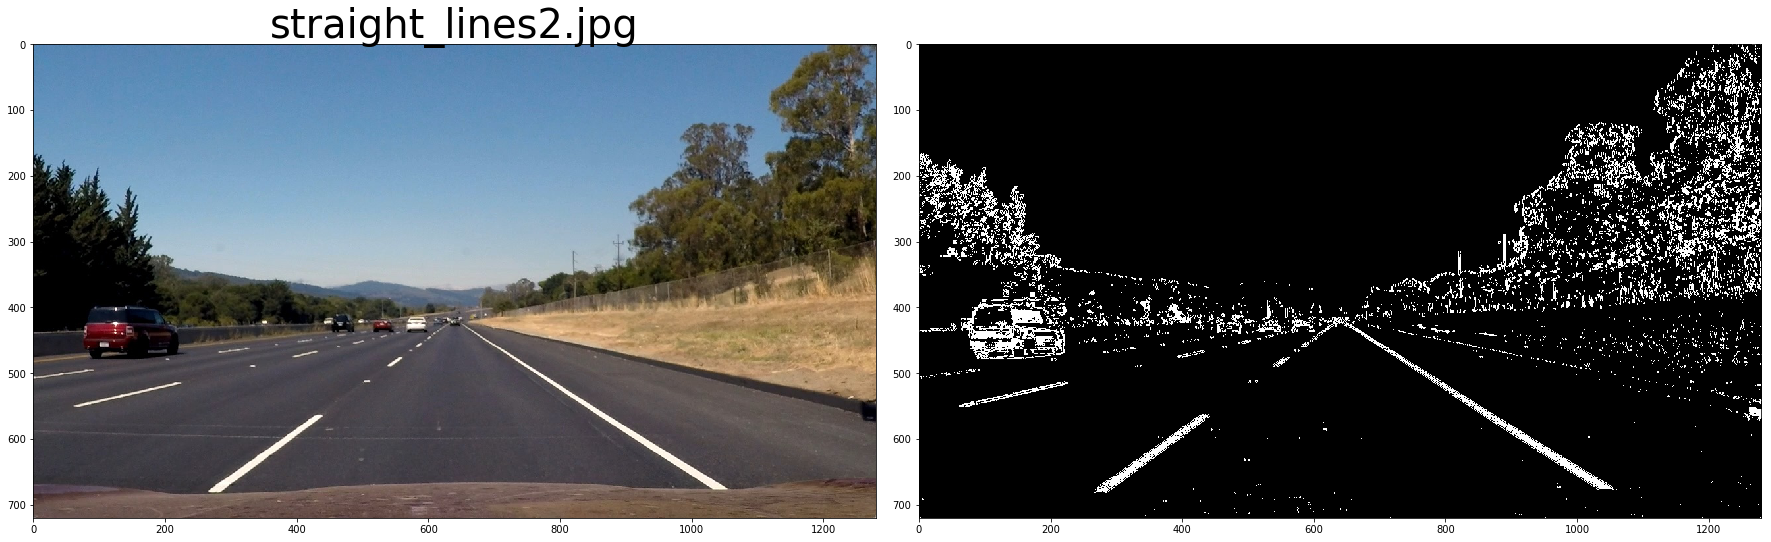

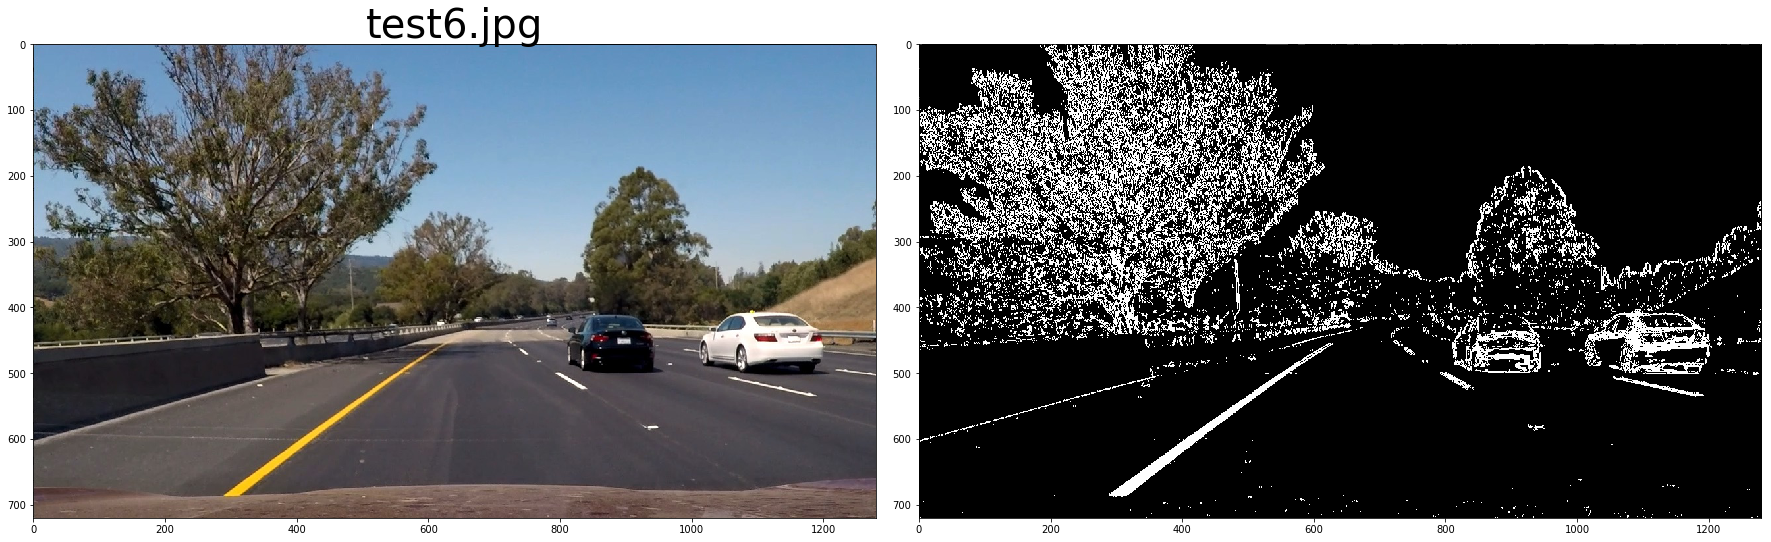

In [5]:
# Edit this function to create your own pipeline.
def convert_to_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1
    
    return combined_binary

for fname in os.listdir('test_images/'):
    image = mplimg.imread('test_images/' + fname)
    result = convert_to_binary(image)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title(fname, fontsize=40)

    ax2.imshow(result, cmap='gray')
#     ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective transform

In [ ]:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('test_image2.png')
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # 4) If corners found: 
    if ret:
            # a) draw corners
            cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            src = np.float32([[corners[0][0][0], corners[0][0][1]],
                              [corners[nx-1][0][0], corners[nx-1][0][1]],
                              [corners[nx*(ny-1)][0][0], corners[nx*(ny-1)][0][1]],
                              [corners[nx*ny-1][0][0], corners[nx*ny-1][0][1]]])
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            offset = 100
            dst = np.float32([[offset,offset],      
                              [img.shape[1]-offset, offset],
                              [offset, img.shape[0]-offset], 
                              [img.shape[1]-offset,img.shape[0]-offset]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            M = cv2.getPerspectiveTransform(src, dst)
            # e) use cv2.warpPerspective() to warp your image to a top-down view
            img_size = (img.shape[1], img.shape[0])
            warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    #delete the next two lines
    # M = None
    # warped = undist
    return warped, M

# Processing pipeline

1. Correct for distortion
2. Transform RGB to binary image
3. Perform perspective transform to create "top view"
4. Polynomial fit on left and right lanes
5. Get R-curvature
